### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

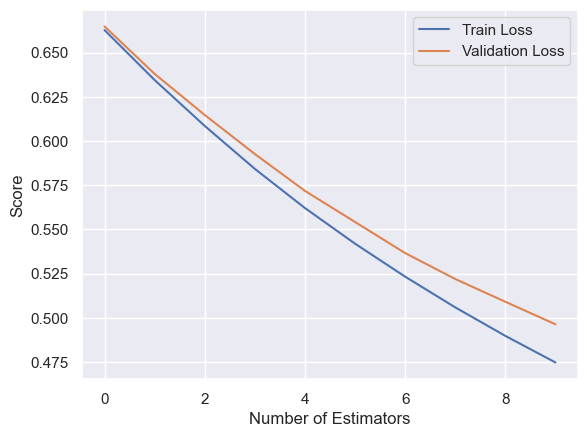

CPU times: total: 438 ms
Wall time: 1.56 s
Train ROC-AUC 0.9863
Valid ROC-AUC 0.9462
Test ROC-AUC 0.9435


In [6]:
boosting = Boosting(plot=True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}') 

## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

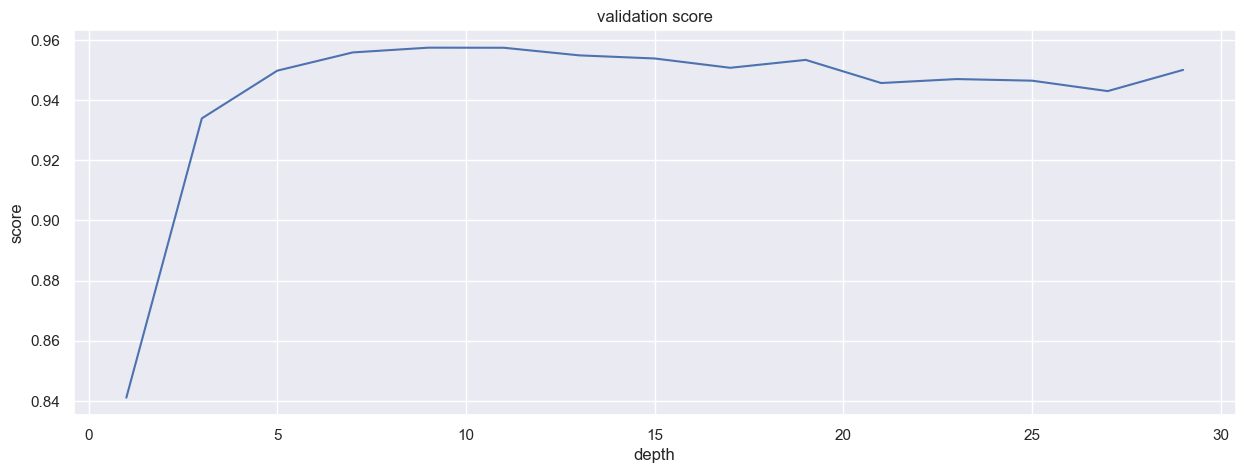

In [7]:
results = {}

depths = range(1, 30, 2)

### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
from matplotlib import pyplot as plt

for depth in depths:
    boosting = Boosting(plot=False, base_model_params={"max_depth": depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results[depth] = boosting.score(x_valid, y_valid)

plt.figure(figsize=(15,5))
plt.plot(range(1, 30, 2), results.values())
plt.title('validation score')
plt.xlabel('depth')
plt.ylabel('score')
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**
чисто на глаз глубина 7 это самое чоткое что может быть в этой жизни. Дерево плюс минус неглубокое, и имеет приемлимую обобщающую способность )
╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

[I 2024-06-12 07:54:45,258] A new study created in memory with name: no-name-7eb4826a-62eb-4543-8dd3-6d5d39b737f2
[I 2024-06-12 07:54:47,317] Trial 0 finished with value: 0.9381619634802436 and parameters: {'n_estimators': 70, 'learning_rate': 0.96, 'subsample': 0.4, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.9381619634802436.
[I 2024-06-12 07:54:57,326] Trial 1 finished with value: 0.9560699129519692 and parameters: {'n_estimators': 90, 'learning_rate': 0.7100000000000001, 'subsample': 0.5, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9560699129519692.
[I 2024-06-12 07:54:58,444] Trial 2 finished with value: 0.9396005627809615 and parameters: {'n_estimators': 40, 'learning_rate': 0.8600000000000001, 'subsample': 0.3, 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.9560699129519692.
[I 2024-06-12 07:55:00,025] Trial 3 finished with valu

Best hyperparameters:  {'n_estimators': 80, 'learning_rate': 0.51, 'subsample': 0.6000000000000001, 'max_depth': 11, 'min_samples_split': 27, 'min_samples_leaf': 9}


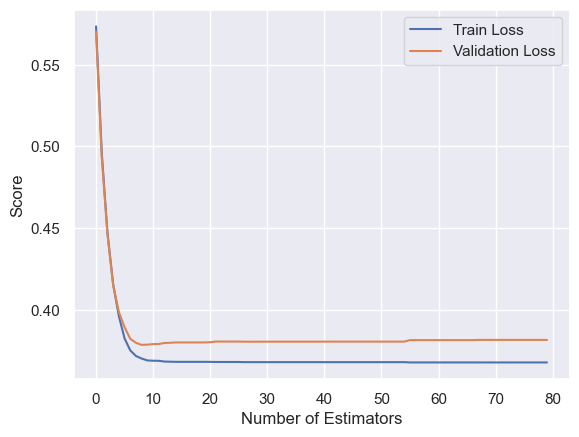

Train ROC-AUC: 0.9732
Valid ROC-AUC: 0.9609


In [8]:
import optuna


def objective(trial):
    boosting = Boosting(
        plot=False,
        n_estimators=trial.suggest_int('n_estimators', 10, 100, step=10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, step=0.05),
        subsample=trial.suggest_float('subsample', 0.3, 0.7, step=0.1),
        base_model_params={
            "max_depth": trial.suggest_int('max_depth', 3, 15, step=2),
            "min_samples_split": trial.suggest_int('min_samples_split', 3, 30, step=2),
            "min_samples_leaf": trial.suggest_int('min_samples_leaf', 3, 30, step=2)
        }
    )
    boosting.fit(x_train, y_train, x_valid, y_valid)
    return boosting.score(x_valid, y_valid)

# 2. Создаем объект исследования и оптимизируем целевую функцию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 3. Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)

# 4. Обучаем модель с лучшими параметрами
best_params = study.best_params

final_base_model_params = {
    "max_depth": best_params["max_depth"],
    "min_samples_split": best_params["min_samples_split"],
    "min_samples_leaf": best_params["min_samples_leaf"],
}

final_boosting = Boosting(
    base_model_params=final_base_model_params,
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
    plot=True
)

final_boosting.fit(x_train, y_train, x_valid, y_valid)

# Оценка модели на тренировочной и валидационной выборках
print(f'Train ROC-AUC: {final_boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC: {final_boosting.score(x_valid, y_valid):.4f}')

# print(f'Test ROC-AUC: {final_boosting.score(x_test, y_test):.4f}')

## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [9]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

In [10]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [11]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [12]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [13]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
